## MultiLayerPerceptron

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class NumberSumDataset(Dataset):
    def __init__(self, data_range=(1, 10)):
        self.numbers = list(range(data_range[0], data_range[1]))

    def __getitem__(self, index):
        number1 = float(self.numbers[index // len(self.numbers)])
        number2 = float(self.numbers[index % len(self.numbers)])
        return torch.tensor([number1, number2]), torch.tensor([number1 + number2])

    def __len__(self):
        return len(self.numbers) ** 2

## 2 Custom Dataset: NumberSumDataset

In [10]:
class NumberSumDataset(Dataset):
    """
    A synthetic dataset that returns every ordered pair (i, j)
    in a specified range and labels it with their sum.

    Example with range (1, 4):
        index 0 → (1, 1) →  2
        index 1 → (1, 2) →  3
        index 2 → (1, 3) →  4
        index 3 → (2, 1) →  3
        ...
    """
    def __init__(self, data_range=(1, 10)):
        # Store all integers in the range [start, end)
        self.numbers = list(range(*data_range))

    def __len__(self):
        # Total ordered pairs = N²
        return len(self.numbers) ** 2

    def __getitem__(self, index):
        """
        Map the flat index to a 2-D index:
            row = index // N
            col = index %  N
        """
        N = len(self.numbers)
        number1 = float(self.numbers[index // N])   # row element
        number2 = float(self.numbers[index %  N])   # column element
        pair     = torch.tensor([number1, number2])
        the_sum  = torch.tensor([number1 + number2])
        return pair, the_sum

### Quick sanity-check:

In [11]:
toy_set = NumberSumDataset(data_range=(1, 6))
for i in range(5):
    print(toy_set[i])

(tensor([1., 1.]), tensor([2.]))
(tensor([1., 2.]), tensor([3.]))
(tensor([1., 3.]), tensor([4.]))
(tensor([1., 4.]), tensor([5.]))
(tensor([1., 5.]), tensor([6.]))


## 3 Define an MLP Model

In [12]:
class MLP(nn.Module):
    """
    A simple 2-layer feed-forward network that learns f(x, y) = x + y.
    """
    def __init__(self, input_size: int = 2, hidden_size: int = 128):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.out    = nn.Linear(hidden_size, 1)
        self.act    = nn.ReLU()

    def forward(self, x):
        x = self.act(self.hidden(x))
        return self.out(x)

## 4 Create DataLoader, Model, Loss, Optimizer

In [13]:
# Full dataset: numbers 0‒99  →  100² = 10 000 samples
dataset    = NumberSumDataset(data_range=(0, 100))
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

model        = MLP(input_size=2)
criterion    = nn.MSELoss()
optimizer    = optim.Adam(model.parameters(), lr=1e-3)

## 5 Training Loop

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0

    for pairs, targets in dataloader:
        preds = model(pairs)              # forward pass
        loss  = criterion(preds, targets) # compute loss

        loss.backward()                   # back-prop
        optimizer.step()                  # update weights
        optimizer.zero_grad()             # reset gradients

        running_loss += loss.item()

    print(f"Epoch {epoch:2d} — total batch loss: {running_loss:.5f}")

Epoch  0 — total batch loss: 240244.33343
Epoch  1 — total batch loss: 2406.13129
Epoch  2 — total batch loss: 746.29922
Epoch  3 — total batch loss: 67.56002
Epoch  4 — total batch loss: 1.69477
Epoch  5 — total batch loss: 1.12241
Epoch  6 — total batch loss: 0.89274
Epoch  7 — total batch loss: 0.66531
Epoch  8 — total batch loss: 0.55421
Epoch  9 — total batch loss: 0.49038


## 6 Quick Test

In [15]:
with torch.no_grad():
    test_pair = torch.tensor([3.0, 7.0])
    prediction = model(test_pair)
    print(f"Model prediction for 3 + 7 ≈ {prediction.item():.4f}")

Model prediction for 3 + 7 ≈ 10.0564


# Detailed Walk-Through of a Two-Layer MLP for Addition

## 1  Network Architecture and Shapes

| Layer | Weight matrix shape | Bias shape | Purpose |
|-------|--------------------|------------|---------|
| **Hidden (L₁)** | 128 × 2 | 128 | Project 2-D input → 128 hidden neurons |
| **ReLU** | — | — | Non-linearity (zeroes negatives) |
| **Output (L₂)** | 1 × 128 | 1 | Reduce 128 features → single scalar |

> *Only two trainable `Linear` layers ⇒ a **1-hidden-layer network**.<br>
> In this example we’ll shrink the hidden layer to **3 neurons** so the math is easy to see.*

## 2  Forward Pass (single sample \([3,7]\))

Assume tiny, fixed parameters:
W₁ = [[ 0.10, 0.20],
[-0.40, 0.30],
[ 0.05, -0.10]]
b₁ = [0.01, 0.00, -0.02]

W₂ = [[ 0.60, -0.20, 0.40]]
b₂ = [0.03]



### 1. Hidden Linear Transform

$$
\begin{aligned}
\mathbf{z}_1 &= W_1 \cdot \mathbf{x} + \mathbf{b}_1 \\
&= \begin{bmatrix}
0.10 \cdot 3 + 0.20 \cdot 7 + 0.01 \\
-0.40 \cdot 3 + 0.30 \cdot 7 + 0.00 \\
0.05 \cdot 3 + (-0.10) \cdot 7 - 0.02
\end{bmatrix} \\
&= \begin{bmatrix}
1.81 \\
0.90 \\
-0.47
\end{bmatrix}
\end{aligned}
$$

### 2. ReLU Activation

$$
\mathbf{h} = \text{ReLU}(\mathbf{z}_1) =
\begin{bmatrix}
1.81 \\
0.90 \\
0
\end{bmatrix}
$$

### 3. Output Layer

$$
\hat{y} = W_2 \cdot \mathbf{h} + b_2 = 0.6 \cdot 1.81 + (-0.2) \cdot 0.90 + 0.4 \cdot 0 + 0.03 = 1.116
$$

The untrained network predicts:

$$
\hat{y} \approx 1.12 \quad \text{(instead of the correct sum } y = 10\text{)}
$$




## 3. Loss and Backpropagation

---

### 3.1 Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** is the most commonly used loss function for regression problems. It computes the average of the squares of the differences between predicted and actual values.

For example, suppose your model predicts:

$$
\hat{y} = 1.116, \quad y = 10
$$

Then the loss is:

$$
L = (\hat{y} - y)^2 = (1.116 - 10)^2 \approx 79.3
$$

---

### 3.1.1 Understanding Loss Functions: MSE and Alternatives

Loss functions quantify how well (or badly) your model is performing. They form the basis for updating weights using gradients.

#### 🔹 Mean Squared Error (MSE)

Used for **regression tasks**:

$$
L = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
$$

- Sensitive to large errors
- Squared term amplifies outliers
- Used when precision is key

#### 🔹 Mean Absolute Error (MAE)

$$
L = \frac{1}{n} \sum_{i=1}^n |\hat{y}_i - y_i|
$$

- Less sensitive to outliers
- Does not penalize large deviations as harshly as MSE

#### 🔹 Cross-Entropy Loss

- Used for **classification**
- Not suitable for regression tasks like addition

#### 🔹 Huber Loss

A hybrid between MSE and MAE — it uses MSE when the error is small and MAE when it's large.

---

### 3.2 Gradient Flow

Once the loss is computed, we use **backpropagation** to compute the gradients — these indicate how each weight and bias should change to reduce the loss.

#### 1️⃣ Gradient at Output:

$$
\frac{\partial L}{\partial \hat{y}} = 2(\hat{y} - y) = -17.77
$$

This is the derivative of the loss function with respect to the model’s prediction.

#### 2️⃣ Gradient w.r.t. Output Layer (W₂ and b₂):

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial \hat{y}} \cdot \mathbf{h}^\top
$$

- \( \mathbf{h} \): hidden layer activation
- Shape: [1 × hidden_size]

#### 3️⃣ Gradient w.r.t Hidden Activations:

$$
\frac{\partial L}{\partial \mathbf{h}} = \frac{\partial L}{\partial \hat{y}} \cdot W_2^\top
$$

This propagates error back to the hidden layer from the output layer.

#### 4️⃣ ReLU Derivative (Activation Backprop):

The ReLU function blocks gradients for negative inputs:

$$
\frac{\partial L}{\partial \mathbf{z}_1} = \frac{\partial L}{\partial \mathbf{h}} \cdot \text{ReLU}'(\mathbf{z}_1)
$$

- Only positive neurons in \( \mathbf{z}_1 \) pass gradient through
- Others get zero

#### 5️⃣ Gradient w.r.t Hidden Layer Weights (W₁ and b₁):

$$
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial \mathbf{z}_1} \cdot \mathbf{x}^\top
$$

- \( \mathbf{x} \): input vector

---

### 3.3 Parameter Update

After calculating gradients, the **optimizer** updates each parameter to reduce the loss.

#### Formula:

$$
\theta \leftarrow \theta - \eta \cdot \frac{\partial L}{\partial \theta}
$$

- \( \theta \): weight or bias
- \( \eta \): learning rate (controls step size)

---

### 3.3.1 Optimizers

#### 🔹 SGD (Stochastic Gradient Descent)

$$
\theta = \theta - \eta \cdot \frac{\partial L}{\partial \theta}
$$

- Simple and effective
- May be slow to converge

#### 🔹 Adam (Adaptive Moment Estimation)

- **Used in your MLP model**
- Combines momentum + adaptive learning rates
- Faster and more robust for most tasks

**PyTorch handles this via**:
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 4  Why “128” Hidden Neurons?

* **Not** 128 layers—just **128 neurons** *in one layer*.  
* More neurons ⇒ higher capacity to learn complex functions.  
* Output stays scalar because the last layer has `out_features = 1`.  
* For simple addition, even 3–10 neurons can reach zero error; 128 is comfortable over-capacity.

## 5  End-to-End Summary

Input (2) → Linear (2, 128) → ReLU → Linear (128, 1) → Output (1)

* **Layers = sets of weights** (2 trainable layers here).  
* **Neurons per layer = width** (128 hidden).  
* `loss.backward()` auto-computes all gradients; `optimizer.step()` updates them.  
* After training, the network converges to \(\hat y \approx x_1 + x_2\).

In [25]:
import torch, torch.nn as nn

demo_net = nn.Sequential(
    nn.Linear(2, 3, bias=True),
    nn.ReLU(),
    nn.Linear(3, 1, bias=True)
)

with torch.no_grad():
    demo_net[0].weight[:] = torch.tensor([[0.10, 0.20],
                                          [-0.40, 0.30],
                                          [0.05, -0.10]])
    demo_net[0].bias[:]   = torch.tensor([0.01, 0.00, -0.02])
    demo_net[2].weight[:] = torch.tensor([[0.60, -0.20, 0.40]])
    demo_net[2].bias[:]   = torch.tensor([0.03])

x = torch.tensor([[3., 7.]])
print("Prediction for 3 + 7  → ", demo_net(x).item())

Prediction for 3 + 7  →  0.8759999871253967


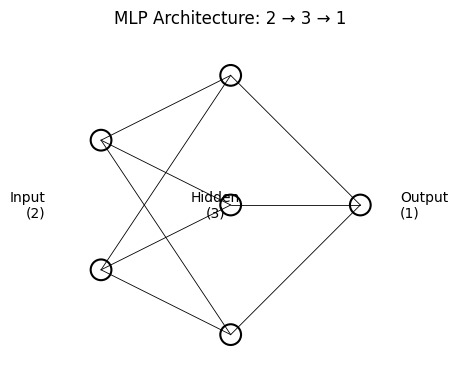

In [23]:
import matplotlib.pyplot as plt

# ---------- quick visual: 2 → 3 → 1 ----------
layer_sizes = [2, 3, 1]
layer_x = [0, 1, 2]
coords = []

for lx, n in zip(layer_x, layer_sizes):
    ys = [i - (n - 1) / 2 for i in range(n)]
    coords.append([(lx, y) for y in ys])

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_aspect('equal')
ax.axis('off')

# nodes
for layer in coords:
    for (x, y) in layer:
        ax.add_patch(plt.Circle((x, y), 0.08, fill=False, lw=1.5))

# edges
for i in range(len(coords) - 1):
    for (x1, y1) in coords[i]:
        for (x2, y2) in coords[i + 1]:
            ax.plot([x1, x2], [y1, y2], 'k-', lw=0.6)

# labels
ax.text(-0.1, 0.5, 'Input\n(2)', ha='right', va='center', fontsize=10, transform=ax.transAxes)
ax.text(0.45, 0.5, 'Hidden\n(3)', ha='center', va='center', fontsize=10, transform=ax.transAxes)
ax.text(1.05, 0.5, 'Output\n(1)', ha='left', va='center', fontsize=10, transform=ax.transAxes)

plt.title("MLP Architecture: 2 → 3 → 1", pad=20)
plt.show()